<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-FranciscoMedellin/blob/main/Actividad_Semanal_7_kmeans_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad Semanal -- 7  Regresiones y K means
- Materia: Ciencia y Analítica de Datos.
- Nombre de la entrega: Actividad Semanal 7 Regresiones y K means
- Fecha: 09/11/2022.
- Francisco Medellin Zertuche - A01794044.
- Profesor titular: María de la Paz Rico Fernández.
- Profesor tutor: Roberto Antonio Guevara González.

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 708 kB/s 
     |████████████████████████████████| 1.0 MB 49.9 MB/s 
     |████████████████████████████████| 1.7 MB 53.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 51.7 MB/s 
     |████████████████████████████████| 6.3 MB 44.6 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=dc2125b40328970e2e470c353f5c8f35c55eb900dcdb1ec8e33533d7eecbcf46
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=6fd4e2caf2c97ccb1afcc243d29db140599fb40ce246b9f68cd96c793cc11af9
  Stored in directory: /root/.

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [ ]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [ ]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [ ]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

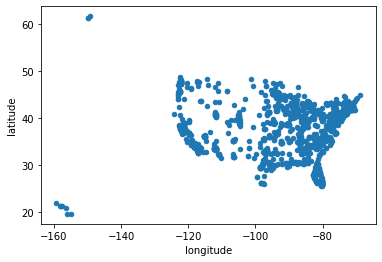

In [ ]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [ ]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

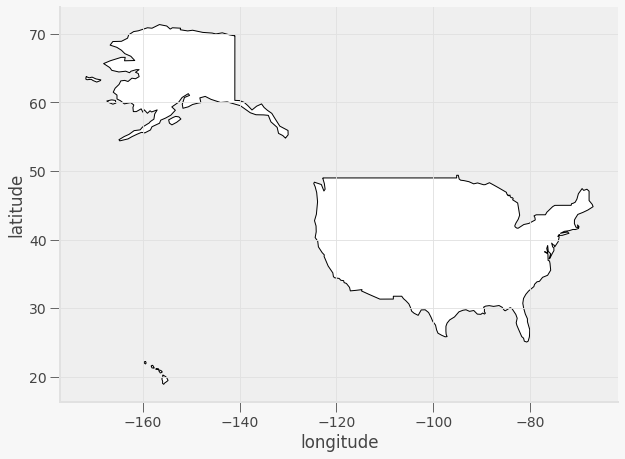

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

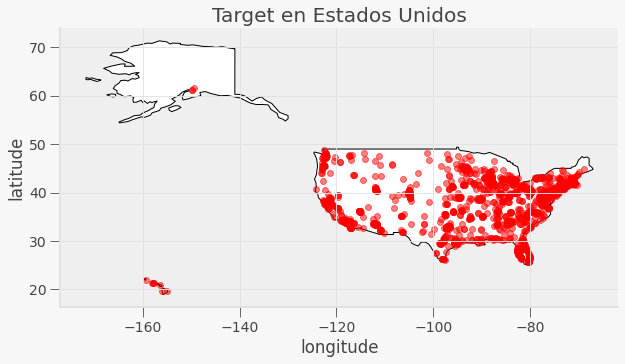

In [ ]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

<h2>Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber dónde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.<h2>

## Implementa K means

Importamos las librerias necesarias para K-Means

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Seleccionamos los datos de latitud y longitud

In [ ]:
X = df[["latitude","longitude"]]
X.head()

,latitude,longitude
0,33.224225,-86.804174
1,33.334550,-86.989778
2,30.602875,-87.895932
3,34.560148,-86.971559
4,31.266061,-85.446422


Visualizemos un modelo k-means con un valore aleatorio de n_clusters.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(latlong)
y_kmeans = kmeans.predict(latlong)

Visualizamos los resultados coloreando los diferentes clusters y sus respectivos centros.

Imprimimos los centros de los clusters: 
 [[  36.54664541  -84.792984  ]
 [  37.57757741 -119.14645561]
 [  40.34198355  -75.26720102]
 [  37.00876203  -96.95719875]]


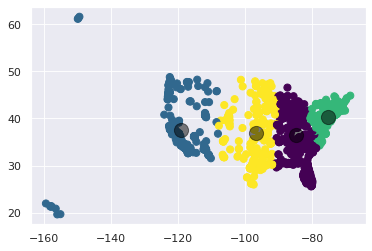

In [ ]:
plt.scatter(latlong["longitude"], latlong["latitude"], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
print("Imprimimos los centros de los clusters: \n",centers)
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

# ¿Cómo elegimos el número de almacenes?

El metodo de optimizacion que se usara es silhouette analysis, el cual mediante el silhouette score nos da una idea del numero optimo de clusters que necesitamos.<br>

Cuando el coeficiente silhouette se acerce a +1 significara que la instancia de los puntos esta bien dentro del cluster al que ya pertenece, mientras que un coeficiente cercano a 0 significara que la instancia del punto esta cerca del perimetro del cluster. Finalmente un coeficiente cercano a -1 significa que la instancia de un punto tal ves ha sido asignada al cluster equivocado.

Genaramos n modelos al azar para poder obtener multiples silhouette scores y seleccionar el mejor.

In [ ]:
kmeans_per_k = [ KMeans(n_clusters=k, random_state=42).fit(latlong) for k in range(1, 11) ]

Busquemos el silhouette score el cual es la media del coeficiente silhouette de cada instancia (punto o valor de datos).

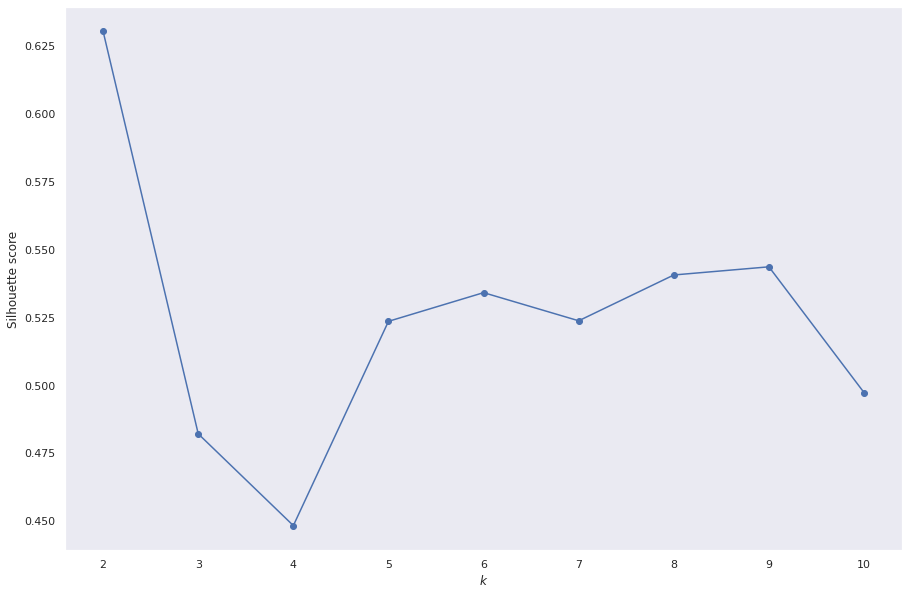

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(latlong, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(15, 10))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

Mediante silhouette podemos ver que el mejor score es el de k=2 y que k=5 es el proximo a tener un buen score.

Con esto podemos deducit que 2 o 5 almacenes para el pais de Estados Unidos serian una buena opcion.

Por cuestiones de tiempos para entregas y costos de envio mas accesibles 5 para ser la mejor opcion.

## Justificacion Tecnica de la respuesta

Comprobemos mediante el metodo del codo y el diagrama silhouette.

**Metodo del Codo**

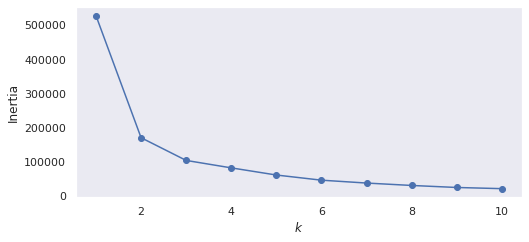

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
# plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
#              arrowprops=dict(facecolor='black', shrink=0.1))
# plt.text(4.5, 650, "Elbow", horizontalalignment="center")
# plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

Vemos que los codos mas visibles codos de la curva  estan en K=2 y en k=5.

Ahora necesitamos conocer cual de ellos es la mejor opcion

**Diagrama silhouette**

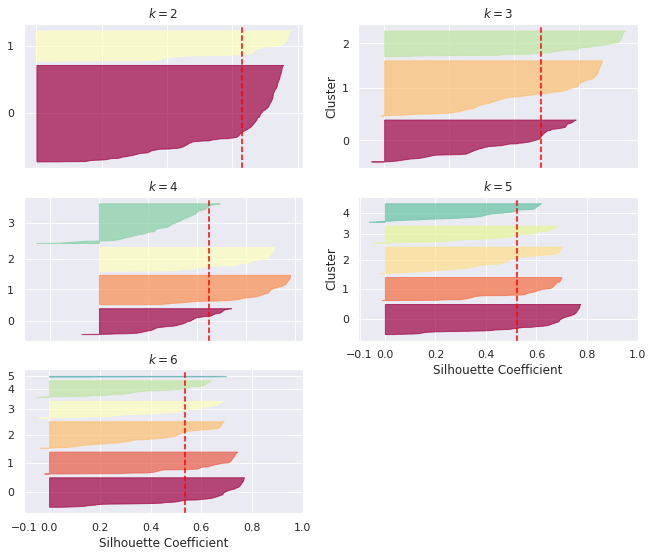

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5, 6):
    plt.subplot(3, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(latlong, y_pred)

    padding = len(latlong) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

- Conociendo que los posibles codos son k=2 y k=5.

- Con k=2 podemos ver buena distribucion pero tal vez existan mejores opciones que tengan una mayor cantidad de clusters.

- Con k=5 ahora podemos ver es el mejor, ya que sus clusters son casi del mismo tamaño y todos cruzan la linea roja que representa el silhouette score.

- Respuesta final: 5 Almacenes en estados unidos son la mejor opcion

# Latitudes y longitudes de los almacenes,

Las latitudes y longitudes de nuestros almacenes son: 
 [[  37.57977424 -119.17634307]
 [  40.32914233  -75.63465582]
 [  34.42035677  -98.26633716]
 [  41.77634657  -88.39926686]
 [  31.08552671  -82.9445307 ]]


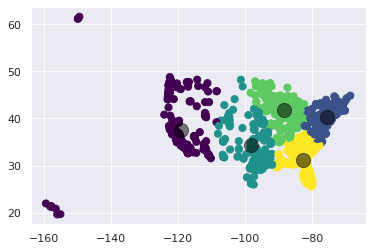

In [ ]:
# Entrenemos nuestro modelo con n_clusters = 5
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(latlong)
y_kmeans = kmeans.predict(latlong)

# Grafica para anlisis visual de nuestros clusters y locacion de los almacenes
plt.scatter(latlong["longitude"], latlong["latitude"], c = y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
print("Las latitudes y longitudes de nuestros almacenes son: \n",centers)
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)

**Las latitudes y longitudes de nuestros almacenes son:** 
- [  37.57977424 -119.17634307]
- [  34.40676796  -98.24207528]
- [  40.34589747  -75.59822436]
- [  31.0894544   -82.8883261 ]
- [  41.74621079  -88.36689969]

##  ¿Qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?




In [ ]:
kmeans.cluster_centers_

array([[  37.57977424, -119.17634307],
       [  40.32914233,  -75.63465582],
       [  34.42035677,  -98.26633716],
       [  41.77634657,  -88.39926686],
       [  31.08552671,  -82.9445307 ]])

Funcion para distancia

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia

### **Datos Almacen 1**

**Ubicacion del almacen 1**

In [ ]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
temp = df[(df['latitude']>=(kmeans.cluster_centers_[0][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[0][0]+0.5)) & 
   (df['longitude']<=(kmeans.cluster_centers_[0][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[0][1]-1.8))
]
city =  np.array(temp["name"])[0]
print(city)
temp

Riverbank


,name,latitude,longitude,address,phone,website,Coordinates
164,Riverbank,37.713792,-120.952674,"2425 Claribel Rd, Riverbank, CA 95367-9456",209-863-1270,https://www.target.com/sl/riverbank/2096,POINT (-120.95267 37.71379)


**A que distancia esta del centro del cluster?**

Para esto utilizaremos  la fórmula de Harvesine que nos da la distancia entre dos coordenadas geograficas

In [ ]:
import math
import numpy as np
import pandas as pd

def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia

# arrays de coordeanadas - lat - long
p_city = df[df["name"]==city]
p_city = np.array(p_city[["latitude","longitude"]])[0,:] # convert to one dimension
p_center = np.array(centers[0])

print("Coordenadas: ",p_city, p_center)

dist = haversine(p_city[0],p_city[1], p_center[0], p_center[1])
print(f"Distancia  del centro del cluster a la ciudad mas cercana: {dist} KM")

Coordenadas:  [  37.7137916 -120.9526744] [  37.57977424 -119.17634307]
Distancia  del centro del cluster a la ciudad mas cercana: 157.14404692661603 KM


**A cuantas tiendas va a surtir?**

In [ ]:
dft = pd.DataFrame(kmeans.labels_)
dft.columns =["clusters"]
num_tiendas = len(dft[dft["clusters"]==0])
print(f"Numero de tiendas a surtir para el almacen 1: {num_tiendas}")

Numero de tiendas a surtir para el almacen 1: 368


### **Datos Almacen 2**

**Ubicacion del almacen 2**

In [ ]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
temp = df[(df['latitude']>=(kmeans.cluster_centers_[1][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[1][0]+0.3)) & 
   (df['longitude']<=(kmeans.cluster_centers_[1][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[1][1]-0.3))
]
print("Centro del cluster: ", kmeans.cluster_centers_[1][:])
city =  np.array(temp["name"])[0]
print(city)
temp

Centro del cluster:  [ 40.32914233 -75.63465582]
Muhlenberg Township


,name,latitude,longitude,address,phone,website,Coordinates
1415,Muhlenberg Township,40.397834,-75.929449,"4220 N 5th Street Hwy, Temple, PA 19560-1738",610-921-5140,https://www.target.com/sl/muhlenberg-township/...,POINT (-75.92945 40.39783)


**A que distancia esta del centro del cluster?**

In [ ]:
import math
import numpy as np
import pandas as pd

# arrays de coordeanadas - lat - long
print(city)
p_city = df[df["name"]==city]
p_city = np.array(p_city[["latitude","longitude"]])[0,:] # convert to one dimension
p_center = np.array(centers[1])

print("Coordenadas: ",p_city, p_center)

dist = haversine(p_city[0],p_city[1], p_center[0], p_center[1])
print(f"Distancia  del centro del cluster a la ciudad mas cercana: {dist} KM")

Muhlenberg Township
Coordenadas:  [ 40.397834 -75.929449] [ 40.32914233 -75.63465582]
Distancia  del centro del cluster a la ciudad mas cercana: 26.12556247058 KM


**A cuantas tiendas va a surtir?**

In [ ]:
dft = pd.DataFrame(kmeans.labels_)
dft.columns =["clusters"]
num_tiendas = len(dft[dft["clusters"]==1])
print(f"Numero de tiendas a surtir para el almacen 2: {num_tiendas}")

Numero de tiendas a surtir para el almacen 2: 482


### **Datos Almacen 3**

**Ubicacion del almacen 3**

In [ ]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
i = 3
temp = df[(df['latitude']>=(kmeans.cluster_centers_[i-1][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[i-1][0]+0.3)) & 
   (df['longitude']<=(kmeans.cluster_centers_[i-1][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[i-1][1]-0.3))
]
print("Centro del cluster: ", kmeans.cluster_centers_[i-1][:])
city =  np.array(temp["name"])[0]
print(city)
temp

Centro del cluster:  [ 34.42035677 -98.26633716]
Lawton


,name,latitude,longitude,address,phone,website,Coordinates
1345,Lawton,34.629866,-98.495394,"2030 NW 82nd Street, Lawton, OK 73505-2355",580-354-7274,https://www.target.com/sl/lawton/2739,POINT (-98.49539 34.62987)


**A que distancia esta del centro del cluster?**

In [ ]:
import math
import numpy as np
import pandas as pd

# arrays de coordeanadas - lat - long
print(city)
p_city = df[df["name"]==city]
p_city = np.array(p_city[["latitude","longitude"]])[0,:] # convert to one dimension
p_center = np.array(centers[i-1])

print("Coordenadas: ",p_city, p_center)

dist = haversine(p_city[0],p_city[1], p_center[0], p_center[1])
print(f"Distancia  del centro del cluster a la ciudad mas cercana: {dist} KM")

Lawton
Coordenadas:  [ 34.6298655 -98.4953944] [ 34.42035677 -98.26633716]
Distancia  del centro del cluster a la ciudad mas cercana: 31.362496961270605 KM


**A cuantas tiendas va a surtir?**

In [ ]:
dft = pd.DataFrame(kmeans.labels_)
dft.columns =["clusters"]
num_tiendas = len(dft[dft["clusters"]==i-1])
print(f"Numero de tiendas a surtir para el almacen {i}: {num_tiendas}")

Numero de tiendas a surtir para el almacen 3: 296


### **Datos Almacen 4**

**Ubicacion del almacen 4**

In [ ]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
i = 4
temp = df[(df['latitude']>=(kmeans.cluster_centers_[i-1][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[i-1][0]+0.5)) & 
   (df['longitude']<=(kmeans.cluster_centers_[i-1][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[i-1][1]-0.5))
]
print("Centro del cluster: ", kmeans.cluster_centers_[i-1][:])
city =  np.array(temp["name"])[0]
print(city)
temp

Centro del cluster:  [ 41.77634657 -88.39926686]
DeKalb


,name,latitude,longitude,address,phone,website,Coordinates
554,DeKalb,41.955836,-88.725189,"2555 Sycamore Rd, Dekalb, IL 60115-2051",815-787-6970,https://www.target.com/sl/dekalb/2559,POINT (-88.72519 41.95584)


**A que distancia esta del centro del cluster?**

In [ ]:
import math
import numpy as np
import pandas as pd

# arrays de coordeanadas - lat - long
print(city)
p_city = df[df["name"]==city]
p_city = np.array(p_city[["latitude","longitude"]])[0,:] # convert to one dimension
p_center = np.array(centers[i-1])

print("Coordenadas: ",p_city, p_center)

dist = haversine(p_city[0],p_city[1], p_center[0], p_center[1])
print(f"Distancia  del centro del cluster a la ciudad mas cercana: {dist} KM")

DeKalb
Coordenadas:  [ 41.9558357 -88.7251889] [ 41.77634657 -88.39926686]
Distancia  del centro del cluster a la ciudad mas cercana: 33.57620822204735 KM


**A cuantas tiendas va a surtir?**

In [ ]:
dft = pd.DataFrame(kmeans.labels_)
dft.columns =["clusters"]
num_tiendas = len(dft[dft["clusters"]==i-1])
print(f"Numero de tiendas a surtir para el almacen {i}: {num_tiendas}")

Numero de tiendas a surtir para el almacen 4: 420


### **Datos Almacen 5**

**Ubicacion del almacen 5**

In [ ]:
# Usamos los centros y asignamos un rango dentro del cual podrian estar ciudades.
# Utilizamos df que contiene datos de las ciudades y sus coordenadas.
# Jugamos con los filtros
i = 5
temp = df[(df['latitude']>=(kmeans.cluster_centers_[i-1][0])) & 
   (df['latitude']<(kmeans.cluster_centers_[i-1][0]+1.5)) & 
   (df['longitude']<=(kmeans.cluster_centers_[i-1][1])) & 
   (df['longitude']>(kmeans.cluster_centers_[i-1][1]-1.5))
]
print("Centro del cluster: ", kmeans.cluster_centers_[i-1][:])
city =  np.array(temp["name"])[0]
print(city)
temp

Centro del cluster:  [ 31.08552671 -82.9445307 ]
Albany


,name,latitude,longitude,address,phone,website,Coordinates
477,Albany,31.621865,-84.225079,"2721 Dawson Rd, Albany, GA 31707-1672",229-888-1333,https://www.target.com/sl/albany/734,POINT (-84.22508 31.62186)


**A que distancia esta del centro del cluster?**

In [ ]:
import math
import numpy as np
import pandas as pd

# arrays de coordeanadas - lat - long
print(city)
p_city = df[df["name"]==city]
p_city = np.array(p_city[["latitude","longitude"]])[0,:] # convert to one dimension
p_center = np.array(centers[i-1])

print("Coordenadas: ",p_city, p_center)

dist = haversine(p_city[0],p_city[1], p_center[0], p_center[1])
print(f"Distancia  del centro del cluster a la ciudad mas cercana: {dist} KM")

Albany
Coordenadas:  [  37.8833619 -122.3077842] [ 31.08552671 -82.9445307 ]
Distancia  del centro del cluster a la ciudad mas cercana: 3659.2185799060467 KM


**A cuantas tiendas va a surtir?**

In [ ]:
dft = pd.DataFrame(kmeans.labels_)
dft.columns =["clusters"]
num_tiendas = len(dft[dft["clusters"]==i-1])
print(f"Numero de tiendas a surtir para el almacen {i}: {num_tiendas}")

Numero de tiendas a surtir para el almacen 5: 273


# ¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

Por lo visto durante el proceso de este notebook y de una busqueda de informacion los paquetes de python que ayudan en este tipo de casos son:

- Basemap. La cual es una  libreria con clases y de funciones dentro de matplotlib
- Cartopy. Esta libreria es una actualizacion de Basemap la cual  permite cálculos geoespaciales así como gráficas de mapas.
- Geopandas. La mas popular de todas dentro de la comunidad de cientificos de datos. Es una  librería complementaria a pandas que permite graficar mapas desde un dataframe


# ¿Consideras importante que se grafique en un mapa?, ¿por qué?


Por supues que es importante, esto debido a que nos da una idea mas clara de la distribucion de nuestros datos en ciertas zonas y nos ayuda a destacar datos que sin graficarlos en un mapa pueden quedar a la interpretacion como datos atipicos.

# Conclusiones

Con la elaboracion de este notebook, podemos ver como un problema de  de distribucion y la logistica de una cadena de suministros pueden ser aboradado mediante algoritmos de agrupamiento. Es interesante ver como algoritmos como K-Means nos ayudan a optimizar este tipo de decisiones en el mundo real.


Aprendi tambien como este algoritmo de clustering llamado k-means funciona, esto mediante las iteraciones "E-Step" que consisten en asignar a los puntos mas cercanos al centro del cluster; y mediante las iteraciones de M-Step que es cuando se configuran los centros de los clusters a la media de la varianza de un grupo de datos.El proceso de optimizacion mediante las tecnicas de codo o de coeficientes silhouette en lo personal pienso que la experiencia me brindara un uso mas optimo de estas tecnicas.

Por ultimo, mediante las graficas de los mapas es importante destacar que incluso con el analisis obtenido el dia de hoy, se tendrian que analizar cada una de las posibles ciudades a instalar un almacen, seria interesante incluir en este analisis variables como indicadores socioeconomics, geograficos, numero de habitantes o de infrastructura de la ciudad como ferrocarriles, autopistas o aeropuertos mas cercanos. Esto con el fin de abordar el problema de una forma mas real.

# Referencias

Géron, A. (s. f.). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. O’Reilly Online Learning. https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/

VanderPlas, J. (s. f.). Python Data Science Handbook. O’Reilly Online Learning. https://www.oreilly.com/library/view/python-data-science/9781491912126/


